# About:
### This code is used to scrape the Job Name, Link to the posting and the Skills Section of the top 100 job posting from LinkedIn as per the role that is being searched and will export all the data into an excel file. 
## <font color='red'>Before running the code, make sure to insert the username, password and role_searched as per your preference. After inserting, simply run and wait.


In [ ]:
username = "Please Enter your email here"
password = "Please Enter your password here"
role_searched = "Please Enter the rolw you want to search here"

In [ ]:

from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import pandas as pd
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from tqdm import tqdm

driver = webdriver.Chrome(ChromeDriverManager().install())


def checkForExist(page_soup):
    try:
        no_result_message = page_soup.find('h1',{'class':'t-24 t-black t-normal text-align-center'}).text
        return False
    except AttributeError as e:
        return True

def checkForNoOfJobs(page_soup):
    result_count = page_soup.find('div', {'class': 'jobs-search-results-list__subtitle'}).text.strip()
    numbers = re.search(r'\d+', result_count).group()
    return numbers

def scroll_down():
    jobs_block= driver.find_element(By.CSS_SELECTOR, '.jobs-search-results-list')
    jobs_list= jobs_block.find_elements(By.CSS_SELECTOR, '.jobs-search-results__list-item')
    n = 0
    for i in jobs_list:
        n+=1
        driver.execute_script("arguments[0].scrollIntoView();", jobs_list[n-1])

def scrape_new_page(url):
    driver.get(url)
    time.sleep(15)
    scroll_down()
    time.sleep(15)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    scrape_for_skills(soup)


def start_scraping(username,password,role_searched):
    website = "https://www.linkedin.com/home"
    driver.get(website)
    time.sleep(5)
    input_username = driver.find_element(By.ID, "session_key")
    input_username.send_keys(username)
    input_password = driver.find_element(By.ID, "session_password")
    input_password.send_keys(password)
    driver.find_element(By.XPATH, '//*[@id="main-content"]/section[1]/div/div/form/div[2]/button').click()
    time.sleep(10)
    role_proper_syntax = role_searched.replace(" ", "%20")
    website = f"https://www.linkedin.com/jobs/search?keywords={role_proper_syntax}&amp;origin=BLENDED_SEARCH_RESULT_CARD_NAVIGATION"
    driver.get(website)
    time.sleep(15)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    exist = checkForExist(soup)
    if not exist:
        print("No result found for your search!")
        return
    number_of_result = int(checkForNoOfJobs(soup))
    scroll_down()
    time.sleep(15)
    # Create a BeautifulSoup object to parse the page source
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    current_url = driver.current_url
    if number_of_result >= 1:
        scrape_for_skills(soup)
    if number_of_result > 25:
        new_url = current_url + "&start=25"
        scrape_new_page(new_url)
    if number_of_result > 50:
        new_url = current_url + "&start=50"
        scrape_new_page(new_url)
    if number_of_result > 75:
        new_url = current_url + "&start=75"
        scrape_new_page(new_url)
    return

def scrape_for_skills(soup):
    interested_section = soup.find('ul', {'class':'scaffold-layout__list-container'})
    companies_list = interested_section.find_all('a')
    for company in tqdm(companies_list):
        temp_list = []
        # cant use find here because find is method in BeautifulSoup is used to find child elements or content within a tag, not to extract attributes of the tag itself.
        href = company['href']
        # Only uncomment if want to see the href being scraped here
        # print(href)
        full_link = 'https://www.linkedin.com' + str(href)
        driver.get(full_link)
        time.sleep(20)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        job_name = soup.find('h1',{'class':'t-24 t-bold job-details-jobs-unified-top-card__job-title'}).text.strip()
        try:
            driver.find_element(By.CSS_SELECTOR, '[class*="mv5"]').click()
        except NoSuchElementException:
            print("No such element exception")
            continue
        except TimeoutException:
            print("timeout exception here")
            continue
        time.sleep(20)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        interested_skills = soup.find('ul',{'class':'job-details-skill-match-status-list'})
        interested_skills = interested_skills.find_all('li')
        for skill in interested_skills:
            # use True because we want to find all aria label regardless of value the {} expect a dictionary so need to insert a value but in this case since
            # the value might diff because of match/unmatched skill so just use True
            job_skill = skill.find('div',{'aria-label':True}).text.strip()
            temp_list.append(job_skill)
        jobs_list.append(job_name)
        skills_list.append(temp_list)
        link_to_job_list.append(full_link)
        # Only uncomment if want to see the skill being scraped here
        # print(temp_list)
        # print("---------------")

skills_list = []
link_to_job_list = []
jobs_list = []
start_scraping(username,password,role_searched)
df = pd.DataFrame({'job name': jobs_list,
                    'link to job': link_to_job_list,
                    'skill list': skills_list})
df.to_excel('scraped_data_ver2.xlsx',index = False)
print("Scraping Completed!")

### In my case I searched for Data Analyst and export the result into the excel file named "scraped_data_ver2.xlsx" which is also uploaded. Now, import the excel file to do a visualisation of the top 20 skills listed by the 100 roles searched

## <font color='red'>Note: There may not be 100 rows because some of the job postings do not include the skills section, so we ignore it.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('scraped_data_ver2.xlsx')
df

,job name,link to job,skill list
0,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,"['Data Analytics', 'SQL', 'Collaborative Probl..."
1,Data Analyst Intern - Regional Marketing Analy...,https://www.linkedin.com/jobs/view/3611204819/...,"['Python (Programming Language)', 'SQL', 'Defi..."
2,"Data Analyst, Monetization",https://www.linkedin.com/jobs/view/3599788524/...,"['Data Analysis', 'Data Analytics', 'Python (P..."
3,Data Analyst,https://www.linkedin.com/jobs/view/3729120053/...,"['Data Analysis', 'Data Analytics', 'Data Clea..."
4,"Lead BI Analyst (Bangkok-based, Relocation pro...",https://www.linkedin.com/jobs/view/3629308855/...,"['Analytics', 'Data Science', 'Business Case P..."
...,...,...,...
78,Senior Commercial Business Intelligence Analys...,https://www.linkedin.com/jobs/view/3728211136/...,"['Analytics', 'Complex Analysis', 'Distributio..."
79,Business Intelligence Analyst,https://www.linkedin.com/jobs/view/3714213220/...,"['Analytics', 'Accruals', 'Business Intelligen..."
80,Data Analyst - Monetization Strategy & Operati...,https://www.linkedin.com/jobs/view/3700961545/...,"['Adaptation', 'Attention to Detail', 'Busines..."
81,Senior Data Scientist (Quant Trading/Algorithm),https://www.linkedin.com/jobs/view/3713483333/...,"['Data Mining', 'Data Science', 'Machine Learn..."


### At the skill list column, the data is being collected as a whole string even though I want to be in a list. Hence, we need to do a conversion of that column and convert it into a list instead of one long string using the code below

In [2]:
df['skill list'] = df['skill list'].str.strip("[]").str.replace("'", "").str.split(", ")
df

,job name,link to job,skill list
0,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,"[Data Analytics, SQL, Collaborative Problem So..."
1,Data Analyst Intern - Regional Marketing Analy...,https://www.linkedin.com/jobs/view/3611204819/...,"[Python (Programming Language), SQL, Defining ..."
2,"Data Analyst, Monetization",https://www.linkedin.com/jobs/view/3599788524/...,"[Data Analysis, Data Analytics, Python (Progra..."
3,Data Analyst,https://www.linkedin.com/jobs/view/3729120053/...,"[Data Analysis, Data Analytics, Data Cleaning,..."
4,"Lead BI Analyst (Bangkok-based, Relocation pro...",https://www.linkedin.com/jobs/view/3629308855/...,"[Analytics, Data Science, Business Case Prepar..."
...,...,...,...
78,Senior Commercial Business Intelligence Analys...,https://www.linkedin.com/jobs/view/3728211136/...,"[Analytics, Complex Analysis, Distribution Cha..."
79,Business Intelligence Analyst,https://www.linkedin.com/jobs/view/3714213220/...,"[Analytics, Accruals, Business Intelligence (B..."
80,Data Analyst - Monetization Strategy & Operati...,https://www.linkedin.com/jobs/view/3700961545/...,"[Adaptation, Attention to Detail, Business Ins..."
81,Senior Data Scientist (Quant Trading/Algorithm),https://www.linkedin.com/jobs/view/3713483333/...,"[Data Mining, Data Science, Machine Learning, ..."


### Now that the skill list is an actual list, we can perform an explode function so that later on we can do a value_counts() to allow for visualisation

In [4]:
df_exploded = df.explode('skill list', ignore_index=True)
df_exploded

,job name,link to job,skill list
0,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,Data Analytics
1,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,SQL
2,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,Collaborative Problem Solving
3,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,Communication
4,Product Data Scientist - TikTok Data Analysis,https://www.linkedin.com/jobs/view/3345064919/...,Data Extraction
...,...,...,...
691,Business Intelligence Analyst (1 Year Contract),https://www.linkedin.com/jobs/view/3717044456/...,DAX
692,Business Intelligence Analyst (1 Year Contract),https://www.linkedin.com/jobs/view/3717044456/...,System Applications
693,Business Intelligence Analyst (1 Year Contract),https://www.linkedin.com/jobs/view/3717044456/...,User Training
694,Business Intelligence Analyst (1 Year Contract),https://www.linkedin.com/jobs/view/3717044456/...,Visual Basic for Applications (VBA)


### Creating the visualisation of the top 20 skills ranked by their counts which is how frequent they appear in the 100 jobs posting that we scraped

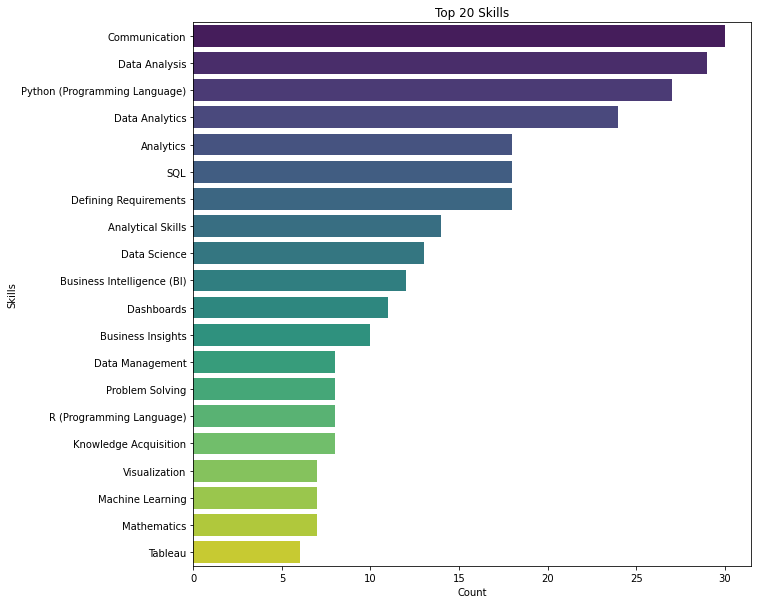

In [7]:
# Count the occurrences of each skill
skill_counts = df_exploded['skill list'].value_counts()

# Select the top 20 skills
top_20_skills = skill_counts.head(20)

# Create a bar chart using seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x=top_20_skills.values, y=top_20_skills.index, palette="viridis")
plt.title('Top 20 Skills')
plt.xlabel('Count')
plt.ylabel('Skills')
plt.show()